**Библиотеки**

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

import time

import matplotlib.pyplot as plt
import seaborn as sns

В представленной задаче необходимо по тексту комментария определить степень его токсичности. Это задача классификации на $K$ классов, которые могут пересекаться:  
<center>$
\begin{equation*}
    Y\in\{0,1\}^K
\end{equation*}$
</center>

возможные классы:
- toxic;
- severe_toxic;
- obscene;
- threat;
- insult;
- identity_hate.

Загрузим имеющиеся данные.

In [2]:
data = pd.read_csv('data/toxic_comment.csv', index_col=0)

In [3]:
data.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [4]:
data.loc['0001b41b1c6bb37e', 'comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

В качестве предварителного анализа рассмотрим распределение классов:

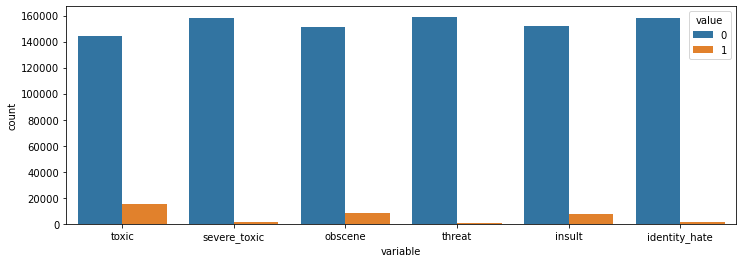

In [5]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(data.drop('comment_text', axis=1)))
plt.show()

Из графика видно, что классы несбалансированны. Это необходимо учитывать при оценке качетсва модели.

Предварительно разобъем выборку на обучение и контроль:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['comment_text'], 
                                                    data.drop('comment_text', axis=1), 
                                                    test_size=0.33,
                                                    random_state=42)

Убедимся, что распределения в выборках совпадают:

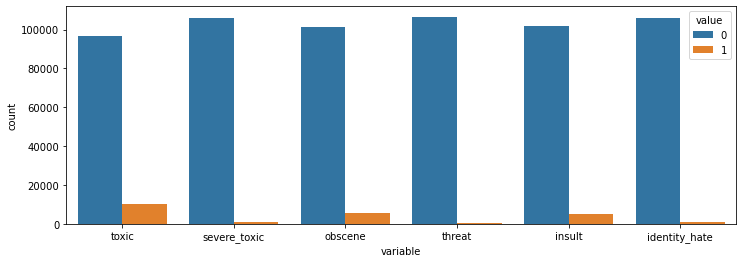

In [8]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(y_train))
plt.show()

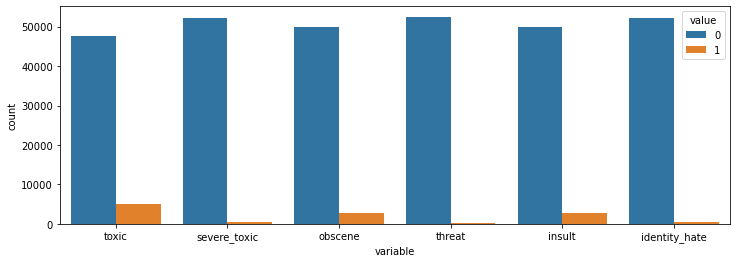

In [9]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(y_test))
plt.show()

**1. Преобразование текстовых данных**
Для преобразования текстов комментариев в числовые векторы воспользуемся методами `CountVectorizer` и `TfIdfVectorizer` из пакета `sklearn`.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Начнем с `TfidfVectorizer`. Чтобы составить корпус слов и посчитать число вхождений каждого слова в комментарии и его частоту встречаемости в других документах, необходимо последовательно применить функции `fit` и `transform` в `TfidfVectorizer`, или же сразу `fit_transform`.

In [11]:
count_vec = TfidfVectorizer(max_features=30000, sublinear_tf=True, 
                            strip_accents='unicode', analyzer='word', 
                            token_pattern=r'\w{1,}')

# max_features - какое кол-во наиболее частых слов запомнить
# sublinear_tf - TF-IDF
# strip_accents - кодировка
# analyzer='word' - слова в качестве признаков
# token_pattern - регулярное выражение для токенов в тексте

In [12]:
comments_vec_train = count_vec.fit_transform(X_train)

In [13]:
comments_vec_train

<106912x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 4701344 stored elements in Compressed Sparse Row format>

Таким образом `TfidfVectorizer` запоминает 30000 наиболее частых слов, которые встречались в комментариях из `X_train`. Всего в корпусе оказалось 149271 слово. Теперь необходимо посчитать количество вхождений каждого из слов корпуса для тестового набора:

In [14]:
comments_vec_test = count_vec.transform(X_test)
# Здесь применяется только transofrm ввиду того, что результаты
# на тестовых данных должны зависеть от обучения на тестовой выборке.
# Обучение ни в коем случае не должно проходить обособленно на бвух выборках.
# Что натренировали, то и проверяем.

In [15]:
comments_vec_test

<52659x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2307197 stored elements in Compressed Sparse Row format>

**2. Построение модели логистической регрессии**  
Решение задачи классификации на пересекающихся $K$ классов может быть сведено к решению $K$ задач бинарной классификации. В задачах с большим количеством признаков хорошие результаты показывают линейные модели.

<div class="alert alert-info">

<h3> Задание 1.</h3>
<p></p>

 <ol>
  <li>Решить поставленную задачу с помощью модели логистической регрессии. Для этого необходимо обучить 6 моделей на полученных векторах текстов comments_vec_train и каждом из столбцов y_train.</li>
 <p></p>

      
  <li>Для тестового набора данных comments_vec_test предсказать, принадлежит ли комментарий к каждому из 6 классов с помощью метода predict.</li>
<p></p>
  

 </ol> 
</div>

In [16]:
from sklearn.linear_model import LogisticRegression

**Пункт 1**

In [17]:
# обучение моделей
def fit_models(X, Y, solver=None, max_iter=None):
    # метод обучения:
    if solver is None:
        solver = 'lbfgs'
    # максимальное количество итераций:
    if max_iter is None:
        max_iter = 100
    # обучение моделей:
    models = []
    for y_col in Y.columns:
        models.append(LogisticRegression(random_state=41, C=1,
                                         solver=solver, max_iter=max_iter,
                                         warm_start=True))
        models[-1].fit(X, Y[y_col])
        print('* Модель на ', y_col, ' обучена')
    print('Обучение всех моделей завершено')
    return models

In [18]:
models = fit_models(comments_vec_train, y_train)

* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено


In [19]:
models

[LogisticRegression(C=1, random_state=41, warm_start=True),
 LogisticRegression(C=1, random_state=41, warm_start=True),
 LogisticRegression(C=1, random_state=41, warm_start=True),
 LogisticRegression(C=1, random_state=41, warm_start=True),
 LogisticRegression(C=1, random_state=41, warm_start=True),
 LogisticRegression(C=1, random_state=41, warm_start=True)]

**Пункт 2**

In [20]:
def predict_models(X_test, models, p=None):
    # p - NumPy массив размера 6 (число целевых признаков)
    pred = np.array([]).reshape(X_test.shape[0], 0)
    if p is None:
        # p = тому, что выставит scikit-learn
        for model in models:
            pf = model.predict(X_test).reshape(-1, 1)
            pred = np.hstack([pred, pf])
        return pred
    # p = пользовательскому значению
    for model,pi in zip(models, p):
        pp = (model.predict_proba(X_test)[:, 1] > pi).reshape(-1, 1)
        # t[:, 1] вернет вероятности принадлежности к первому классу
        pred = np.hstack([pred, pp])
    # возвращается массив (Объект-Класс)
    return pred

Некоторые предсказания:

In [21]:
t = comments_vec_test[52000:52003,:]
t

<3x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 143 stored elements in Compressed Sparse Row format>

In [22]:
predict = predict_models(t, models)
predict

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [23]:
u = comments_vec_test[155,:]
u

<1x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [24]:
predict = predict_models(u, models)
predict

array([[0., 0., 0., 0., 0., 0.]])

In [25]:
p = np.ones(6)* 0.1
predict = predict_models(t, models, p=p)
predict

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [26]:
p = np.array([0.2, 0.05, 0.015, 0.05, 0.15, 0.07])
predict = predict_models(t, models, p=p)
predict

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.]])

**3. Оценка качества модели**
Для оценки качества каждой из моделей воспользуемся $F$-мерой. Оценка качества по всем 6 классам будет проводиться по следующей формуле:
$$F1=\frac{1}{6}\sum_{i=1}^6f1_i$$

<div class="alert alert-info">

<h3> Задание 2.</h3>
<p></p>

 <ol>
  <li>Оценить качество полученной модели по всем 6 классам.</li>
 <p></p>

      
  <li>Провести преобразование текста с помощью метода CountVectorizer и построить модель логистической регрессии аналогично заданию 1. Какого качества удалось достичь?</li>
<p></p>
     
  <li>Рассмотрите другие параметры Tf-Idf преобразования (lowercase, analyzer, stop_words, ngram_range, max_features) и попробуйте улучшить качество предсказаний.</li>
<p></p>
  

 </ol> 
</div>

In [27]:
from sklearn.metrics import f1_score

**Пункт 1**

In [28]:
# Предсказание по всем моделям (по всем классам)
pred = predict_models(comments_vec_test, models)

Перепроверим размеры. Резульат предсказания - матрица (Объекты-Классы):

In [29]:
comments_vec_test.shape

(52659, 30000)

In [30]:
pred.shape

(52659, 6)

In [31]:
def multy_f1_score(Y_test, pred):
    y_cols = Y_test.columns
    f1 = np.array([])
    for i in range(y_cols.shape[0]):
        score = f1_score(Y_test[y_cols[i]], pred[:, i])
        f1 = np.hstack([f1, score])
    return f1

In [32]:
def F1_score(multy_f):
    # multy_f - NumPy array
    return multy_f.sum() / multy_f.shape[0]

In [33]:
multy_f1 = multy_f1_score(y_test, pred)
multy_f1

array([0.73164947, 0.33748271, 0.73180077, 0.26086957, 0.62641509,
       0.24113475])

In [34]:
F1 = F1_score(multy_f1)
F1

0.48822539347524024

In [35]:
# TFidf 0.68 / 0.48

**Пункт 2**

**Преобразование данных**

In [36]:
count_vec_CV = CountVectorizer(max_features=30000,
                               strip_accents='unicode', analyzer='word',
                               token_pattern=r'\w{1,}')

In [37]:
comments_vec_train_CV = count_vec_CV.fit_transform(X_train)

In [38]:
comments_vec_train_CV

<106912x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 4701344 stored elements in Compressed Sparse Row format>

In [39]:
comments_vec_test_CV = count_vec.transform(X_test)

In [40]:
comments_vec_test_CV

<52659x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2307197 stored elements in Compressed Sparse Row format>

**Обучение логистической регрессии**

В варианте данных, полученных ранее, логистическая регрессия не сходится. Воспользуемся методом `MaxAbsScaler` из sklearn для масштабирования разреженных данных:

In [41]:
from sklearn.preprocessing import MaxAbsScaler

In [42]:
sparse_transformer = MaxAbsScaler()

In [43]:
CV_cmnts_scaled_train = sparse_transformer.fit_transform(comments_vec_train_CV)

In [44]:
CV_cmnts_scaled_train

<106912x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 4701344 stored elements in Compressed Sparse Row format>

In [45]:
CV_cmnts_scaled_test = sparse_transformer.transform(comments_vec_test_CV)

In [46]:
CV_cmnts_scaled_test

<52659x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2307197 stored elements in Compressed Sparse Row format>

Масштабирование данных не помогает в случае обучения на `insult`. Попробуем применить метод `newton-cg` вместо стандартного метода `lbfgs`:

In [47]:
models_CV = fit_models(CV_cmnts_scaled_train, y_train, solver='newton-cg')

* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено


In [48]:
models_CV

[LogisticRegression(C=1, random_state=41, solver='newton-cg', warm_start=True),
 LogisticRegression(C=1, random_state=41, solver='newton-cg', warm_start=True),
 LogisticRegression(C=1, random_state=41, solver='newton-cg', warm_start=True),
 LogisticRegression(C=1, random_state=41, solver='newton-cg', warm_start=True),
 LogisticRegression(C=1, random_state=41, solver='newton-cg', warm_start=True),
 LogisticRegression(C=1, random_state=41, solver='newton-cg', warm_start=True)]

**Построение предсказания и проверка качетсва**

In [49]:
pred_CV = predict_models(CV_cmnts_scaled_test, models_CV)

Перепроверка размеров:

In [50]:
CV_cmnts_scaled_test.shape

(52659, 30000)

In [51]:
pred_CV.shape

(52659, 6)

Результат - матрица (Объект-Класс).

Проверка качества:

In [52]:
multy_f1_CV = multy_f1_score(y_test, pred_CV)
multy_f1_CV

array([0.00783546, 0.        , 0.00141193, 0.        , 0.        ,
       0.        ])

In [53]:
F1_CV = F1_score(multy_f1_CV)
F1_CV

0.0015412310418728757

Получили плохой результат

**Обучение на немасштабированных данных, но с увеличением числа итераций**

По умолчанию параметр `max_iter` (число итераций метода обучения) равен 100.

In [54]:
# models_CV = fit_models(comments_vec_train_CV, y_train, max_iter=2000)

In [55]:
# pred_CV = predict_models(CV_cmnts_scaled_test, models_CV)

In [56]:
# multy_f1_CV = multy_f1_score(y_test, pred_CV)
# multy_f1_CV

In [57]:
# F1_CV = F1_score(multy_f1_CV)
# F1_CV

**=)**

**Пункт 3**  
Охватывается также и задание 3

In [58]:
# Рассмотрим гистограму (сверху) и примерно составим несколько
# векторов вероятности
p1 = np.array([0.15, 0.03, 0.1, 0.02, 0.1, 0.05])
p2 = np.array([0.15, 0.05, 0.1, 0.01, 0.1, 0.05])
p3 = np.array([0.2, 0.07, 0.15, 0.05, 0.15, 0.03])
p4 = np.array([0.25, 0.06, 0.13, 0.03, 0.12, 0.025])
p5 = np.array([0.17, 0.02, 0.11, 0.025, 0.9, 0.02])
p6 = np.array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32])
p7 = np.array([0.45, 0.3, 0.4, 0.27, 0.41, 0.27])

params = {
    'max_features': [25000, 30000, 35000, 40000],
    'analyzer': ['word', 'char', 'char_wb'],
    'lowercase': [True, False],
    'stop_words': [{'english'}],
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'p_for_classify': [p1, p2, p3, p4, p5, p6, p7]
}

In [59]:
def make_params_sets(params):
    params_list = []
    for i in params['max_features']:
        for j in params['analyzer']:
            for k in params['lowercase']:
                for z in params['ngram_range']:
                    for l in params['stop_words']:
                        for p in params['p_for_classify']:
                            params_dict = {'max_features': i,
                                           'analyzer': j,
                                           'lowercase': k,
                                           'ngram_range': z,
                                           'stop_words': l,
                                           'p_for_classify': p}
                            params_list.append(params_dict)
    return params_list

Число вариаций гиперпараметров:

In [60]:
all_params = make_params_sets(params)
len(all_params)

504

Число моделей, которые предстоит построить и обучить:

In [61]:
len(all_params) * 6

3024

In [62]:
all_params[172]

{'max_features': 30000,
 'analyzer': 'char',
 'lowercase': True,
 'ngram_range': (1, 1),
 'stop_words': {'english'},
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ])}

In [63]:
def gridSearch(params, X_train, X_test, Y_train, Y_test):
    c_all = len(params)  # Общее число гиперпараметров
    c = 0  # Счетчик для вывода номера итерации
    tested_params = []
    for par in params:
        c += 1
        print('-------| {}/{} |-------'.format(c, c_all))
        print('Набор гиперпараметров:')
        pprint(par)
        # Данные
        print('Преобразование данных в векторы:')
        count_vec = TfidfVectorizer(max_features=par['max_features'],
                                    analyzer=par['analyzer'],
                                    lowercase=par['lowercase'],
                                    ngram_range=par['ngram_range'],
                                    stop_words=par['stop_words'],
                                    sublinear_tf=True, 
                                    strip_accents='unicode', 
                                    token_pattern=r'\w{1,}')
        comments_vec_train = count_vec.fit_transform(X_train)
        print('* X_train преобразован')
        comments_vec_test = count_vec.transform(X_test)
        print('* X_test преобразован')
        # Обучение моделей и проверка качества
        print('Обучение моделей и проверка качества:')
        models = fit_models(comments_vec_train, Y_train, max_iter=300)
        # Проверка качества
        predict = predict_models(comments_vec_test, models,
                                 p=par['p_for_classify'])
        multy_f1 = multy_f1_score(Y_test, predict)
        F1 = F1_score(multy_f1)
        # Добавление результатов в список
        tested_params.append((par, multy_f1, F1))
        print('Проверка гиперпараметров завершена.')
    # Возвращается список кортежей из:
    # набора параметров;
    # f1 по всем признакам;
    # F1 по f1.
    return tested_params

Для примера обучим два набора гиперпарамертов:

In [64]:
test_params = all_params[1:3]
test_params

[{'max_features': 25000,
  'analyzer': 'word',
  'lowercase': True,
  'ngram_range': (1, 1),
  'stop_words': {'english'},
  'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05])},
 {'max_features': 25000,
  'analyzer': 'word',
  'lowercase': True,
  'ngram_range': (1, 1),
  'stop_words': {'english'},
  'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03])}]

In [65]:
results = gridSearch(test_params, X_train, X_test, y_train, y_test)

-------| 1/2 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/2 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучен

F1_score по наборам гиперпараметров:

In [66]:
print(list(map(lambda x: np.round(x[-1], 3), results)))

[0.537, 0.583]


Проведем обучение по всем наборам гиперпараметров:  

In [67]:
def time_now():
    hs = int(time.strftime('%H')) * 3600
    ms = int(time.strftime('%M')) * 60
    s = int(time.strftime('%S'))
    return hs + ms + s

In [68]:
def batched_GridSearch(all_params, X_train, X_test, Y_train, Y_test, k):
    # Количество наборов гиперпараметров должно быть кратно k
    all_results = []
    total_time = 0
    for i in range(0, len(all_params), k):  # пакеты гиперпараметров
        params_batch = all_params[i:i+k]
        print('\n=====| Обработка пакета номер {}/{} |====='.format(int(i/k+1),
                                                                  int(len(all_params)/k)))
        s0 = time_now()  # расчет времени
        try:
            gs_res = gridSearch(params_batch,
                                X_train, X_test,
                                Y_train, Y_test)
            for res_j in gs_res:
                all_results.append(res_j)
            s1 = time_now()  # расчет времени
            ds = s1 - s0  # расчет времени
            total_time += ds  # расчет времени
            print('\nОбработка пакета {} завершена за {} секунд'.format(int(i/k+1), ds))
        except KeyboardInterrupt:
            print('\n!!! Выполнение было прервано пользователем')
            break
            # return -1
        except:
            s1 = time_now()  # расчет времени
            ds = s1 - s0  # расчет времени
            total_time += ds  # расчет времени
            print('!!! В пакете номер {} произошла ошибка. Пакет:'.format(int(i/k+1)))
            pprint(params_batch)
    h, m = int(total_time / 3600), int(total_time / 60) % 60
    s = total_time - (h*3600 + m*60)
    time_str = 'Общее время выполнения: {} секунд или {}ч:{}м:{}с'.format(
        total_time, h, m, s
    )
    print(time_str)
    return all_results

**! Звезду смерти ниже лучше не запускать. Крайний раз работала 16ч:17м:4с.**

In [69]:
bgs_results = batched_GridSearch(all_params, X_train, X_test, y_train, y_test, 6)


=====| Обработка пакета номер 1/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобр

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 7 завершена за 597 секунд

=====| Обработка па

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 9 завершена за 525 секунд

=====| Обработка пакета номер 10/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words'

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char'

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test 

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 16 завершена за 808 секунд

=====| Обр

* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 18 завершена за 955 секунд

=====| Обработка пакета номер 19/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.17 , 

Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобр

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 27 завершена за 431 секунд

=====| Обработка пакета номер 28/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка ги

* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words'

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char'

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобр

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 36 завершена за 433 секунд

=====| Обработка пакета номер 37/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка 

* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.45, 0.3 

Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': '

Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 45 завершена за 541 секунд

=====| Обработка пакета номер 46/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_tra

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test пр

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 54 завершена за 418 секунд

=====| Обработка пакета номер 55/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_wor

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'cha

* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_t

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'ch

* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 63 завершена за 1587 секунд

=====| Обработка пакета номер 64/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.15, 0.03, 0.1 

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобр

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word'

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 72 завершена за 542 секунд

=====| Обработка пакета номер 73/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
 'stop

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer'

* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.

Обработка пакета 81 завершена за 1033 секунд

=====| Обработка пакета номер 82/84 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'p_for_classify': array([0.25 , 0.06 

* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и проверка качества:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'ch

In [70]:
pprint(sorted(bgs_results, key = lambda x: x[2], reverse=True))

[({'analyzer': 'word',
   'lowercase': True,
   'max_features': 40000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
   'stop_words': {'english'}},
  array([0.76040306, 0.47563353, 0.78686281, 0.45697329, 0.72024836,
       0.32598714]),
  0.5876847000263816),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 30000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
   'stop_words': {'english'}},
  array([0.76161164, 0.46705054, 0.78836612, 0.44827586, 0.72086628,
       0.32375741]),
  0.5849879762365608),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 40000,
   'ngram_range': (1, 1),
   'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
   'stop_words': {'english'}},
  array([0.76784219, 0.48178914, 0.799591  , 0.41509434, 0.71244052,
       0.33001808]),
  0.5844625445672542),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 40000,
   'ngra

 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 25000,
   'ngram_range': (1, 1),
   'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
   'stop_words': {'english'}},
  array([0.73806103, 0.3888651 , 0.77135833, 0.29903978, 0.68426547,
       0.4       ]),
  0.546931617456247),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 25000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.73590643, 0.43037975, 0.7489592 , 0.35294118, 0.65943503,
       0.35151515]),
  0.54652278941407),
 ({'analyzer': 'char',
   'lowercase': False,
   'max_features': 35000,
   'ngram_range': (1, 3),
   'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03]),
   'stop_words': {'english'}},
  array([0.73271599, 0.45624271, 0.75106174, 0.37150127, 0.68393614,
       0.28204187]),
  0.5462499531559033),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 25000,
   'ngram_

   'ngram_range': (1, 3),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.72938963, 0.42508711, 0.74550021, 0.33663366, 0.6522037 ,
       0.32872504]),
  0.5362565576234153),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 40000,
   'ngram_range': (1, 3),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.7284737 , 0.42709529, 0.74217273, 0.32835821, 0.65091743,
       0.33333333]),
  0.5350584480395311),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 30000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
   'stop_words': {'english'}},
  array([0.75666075, 0.42130178, 0.74591879, 0.28877005, 0.66308003,
       0.32956381]),
  0.5342158681004767),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 40000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0

 ({'analyzer': 'char',
   'lowercase': False,
   'max_features': 35000,
   'ngram_range': (1, 3),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.72529486, 0.45514223, 0.75641289, 0.16091954, 0.66473344,
       0.34398782]),
  0.5177484631613871),
 ({'analyzer': 'word',
   'lowercase': False,
   'max_features': 40000,
   'ngram_range': (1, 1),
   'p_for_classify': array([0.15, 0.03, 0.1 , 0.02, 0.1 , 0.05]),
   'stop_words': {'english'}},
  array([0.7247439 , 0.36553945, 0.72989018, 0.26597132, 0.66077636,
       0.35652174]),
  0.5172404907488172),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_features': 25000,
   'ngram_range': (1, 3),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.7264615 , 0.4495614 , 0.75721006, 0.14942529, 0.66533422,
       0.35469449]),
  0.5171144941675486),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_features': 30000

 ({'analyzer': 'word',
   'lowercase': False,
   'max_features': 30000,
   'ngram_range': (1, 3),
   'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
   'stop_words': {'english'}},
  array([0.70960207, 0.42609153, 0.71179427, 0.15365551, 0.65536393,
       0.3335439 ]),
  0.49834186867200886),
 ({'analyzer': 'word',
   'lowercase': False,
   'max_features': 30000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.71629114, 0.41050119, 0.71574035, 0.20338983, 0.63904784,
       0.30273752]),
  0.4979513116036651),
 ({'analyzer': 'word',
   'lowercase': False,
   'max_features': 35000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.71509434, 0.40384615, 0.71816638, 0.21590909, 0.63669725,
       0.29773463]),
  0.497907973936202),
 ({'analyzer': 'word',
   'lowercase': False,
   'max_features': 40000,
   '

 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 30000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
   'stop_words': {'english'}},
  array([0.74260931, 0.33677465, 0.76940063, 0.35906643, 0.35398773,
       0.26932163]),
  0.4718600643381233),
 ({'analyzer': 'word',
   'lowercase': True,
   'max_features': 35000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
   'stop_words': {'english'}},
  array([0.74439621, 0.33808845, 0.76940028, 0.36162362, 0.34729064,
       0.27014218]),
  0.4718235621935234),
 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 25000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.61945828, 0.41364136, 0.69003378, 0.2       , 0.58360656,
       0.3196347 ]),
  0.4710624476927762),
 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 300

 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 35000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
   'stop_words': {'english'}},
  array([0.63169041, 0.4374269 , 0.65339614, 0.21994885, 0.57948948,
       0.22981956]),
  0.4586285568836346),
 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 40000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.25 , 0.06 , 0.13 , 0.03 , 0.12 , 0.025]),
   'stop_words': {'english'}},
  array([0.63169041, 0.4374269 , 0.65339614, 0.21994885, 0.57948948,
       0.22981956]),
  0.4586285568836346),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_features': 25000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.62680167, 0.43612335, 0.68695467, 0.12790698, 0.58993476,
       0.27987421]),
  0.4579326066354669),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_featur

   'lowercase': True,
   'max_features': 40000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
   'stop_words': {'english'}},
  array([0.5907697 , 0.42059621, 0.61213361, 0.09615385, 0.55804425,
       0.32261768]),
  0.4333858819485454),
 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 25000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
   'stop_words': {'english'}},
  array([0.5903799 , 0.42162162, 0.61225604, 0.09631728, 0.55558583,
       0.32032147]),
  0.43274702399670145),
 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 30000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.15, 0.05, 0.1 , 0.01, 0.1 , 0.05]),
   'stop_words': {'english'}},
  array([0.5903799 , 0.42162162, 0.61225604, 0.09631728, 0.55558583,
       0.32032147]),
  0.43274702399670145),
 ({'analyzer': 'char',
   'lowercase': True,
   'max_features': 35000,
   'ngram_range': (1, 2),
   

   'max_features': 30000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
   'stop_words': {'english'}},
  array([0.62246897, 0.29474343, 0.62246316, 0.17764471, 0.27290323,
       0.18699187]),
  0.36286922897743706),
 ({'analyzer': 'char',
   'lowercase': False,
   'max_features': 35000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
   'stop_words': {'english'}},
  array([0.62246897, 0.29474343, 0.62246316, 0.17764471, 0.27290323,
       0.18699187]),
  0.36286922897743706),
 ({'analyzer': 'char',
   'lowercase': False,
   'max_features': 40000,
   'ngram_range': (1, 2),
   'p_for_classify': array([0.17 , 0.02 , 0.11 , 0.025, 0.9  , 0.02 ]),
   'stop_words': {'english'}},
  array([0.62246897, 0.29474343, 0.62246316, 0.17764471, 0.27290323,
       0.18699187]),
  0.36286922897743706),
 ({'analyzer': 'char',
   'lowercase': False,
   'max_features': 25000,
   'ngram_range': (1, 1),
   

 ({'analyzer': 'char',
   'lowercase': False,
   'max_features': 40000,
   'ngram_range': (1, 1),
   'p_for_classify': array([0.45, 0.3 , 0.4 , 0.27, 0.41, 0.27]),
   'stop_words': {'english'}},
  array([0.39199889, 0.33124216, 0.41986234, 0.        , 0.34792123,
       0.0750469 ]),
  0.2610119194569744),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_features': 25000,
   'ngram_range': (1, 1),
   'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
   'stop_words': {'english'}},
  array([0.43355756, 0.3046875 , 0.41500994, 0.        , 0.36012862,
       0.0511811 ]),
  0.26076078635819094),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_features': 30000,
   'ngram_range': (1, 1),
   'p_for_classify': array([0.37, 0.32, 0.41, 0.35, 0.39, 0.32]),
   'stop_words': {'english'}},
  array([0.43355756, 0.3046875 , 0.41500994, 0.        , 0.36012862,
       0.0511811 ]),
  0.26076078635819094),
 ({'analyzer': 'char_wb',
   'lowercase': False,
   'max_features': 

Наилучшими параметрами оказались:

In [72]:
sorted(bgs_results, key = lambda x: x[2], reverse=True)[0][0]

{'max_features': 40000,
 'analyzer': 'word',
 'lowercase': True,
 'ngram_range': (1, 2),
 'stop_words': {'english'},
 'p_for_classify': array([0.2 , 0.07, 0.15, 0.05, 0.15, 0.03])}

Заметим, что при реализации поиска наилучшего набора параметра была допущена ошибка, существенно влияющаяся на количество вычислений. Дело в том, что набор вероятностей не относится к `TfidfVectorizer`, таким образом при их переборе большое количество раз обучались одни и те же модели лишь с той целью, чтобы оубчиться на другом нбаоре вероятностей. Исправим данную ошибку и реализуем конструктивный подбор вероятностей.

In [73]:
def improvedMPS(params):
    params_list = []
    for i in params['max_features']:
        for j in params['analyzer']:
            for k in params['lowercase']:
                for z in params['ngram_range']:
                    for l in params['stop_words']:
                        params_dict = {'max_features': i,
                                        'analyzer': j,
                                        'lowercase': k,
                                        'ngram_range': z,
                                        'stop_words': l}
                        params_list.append(params_dict)
    return params_list

In [74]:
params = {
    'max_features': [25000, 30000, 35000, 40000],
    'analyzer': ['word', 'char', 'char_wb'],
    'lowercase': [True, False],
    'stop_words': [{'english'}],
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'p_for_classify': [p1, p2, p3, p4, p5, p6, p7]
}

Число вариаций гиперпараметров:

In [76]:
all_params = improvedMPS(params)
len(all_params)

72

Количество моделей, которые необходимо обучить:

In [78]:
len(all_params) * 6

432

Это в семь раз меньше, чем в предыдущей реализации.

Теперь разберемся с подбором вероятностей. Будем для каждого набора параметров с помощью `f1_score` подбирать вероятности следующим образом. Начиная с $0.49$ будем с шагом $0.01$ уменьшать вероятности до тех пор, пока точность по `f1_score` увеличивается (так плохо работает, поэтому буду просто перебирать все до $0.01$). Такой способ перебора вероятностей будет гораздо эффективней.

In [182]:
def improvedGridSearch(params, X_train, X_test, Y_train, Y_test):
    c_all = len(params)  # Общее число гиперпараметров
    c = 0  # Счетчик для вывода номера итерации
    tested_params = []
    for par in params:
        c += 1
        print('-------| {}/{} |-------'.format(c, c_all))
        print('Набор гиперпараметров:')
        pprint(par)
        # Данные
        print('Преобразование данных в векторы:')
        count_vec = TfidfVectorizer(max_features=par['max_features'],
                                    analyzer=par['analyzer'],
                                    lowercase=par['lowercase'],
                                    ngram_range=par['ngram_range'],
                                    stop_words=par['stop_words'],
                                    sublinear_tf=True, 
                                    strip_accents='unicode', 
                                    token_pattern=r'\w{1,}')
        comments_vec_train = count_vec.fit_transform(X_train)
        print('* X_train преобразован')
        comments_vec_test = count_vec.transform(X_test)
        print('* X_test преобразован')
        # Обучение моделей и подбор вероятностей
        print('Обучение моделей и подбор вероятностей:')
        models = fit_models(comments_vec_train, Y_train, max_iter=300)
        # подбор вероятностей
        probs0 = np.zeros(6) + 0.5
        best_probs = np.zeros(6) + 0.5
        predict = predict_models(comments_vec_test, models, p=probs0)       
        for j, ycol in enumerate(Y_test.columns):
            f10 = f1_score(Y_test[ycol], predict[:, j])
            while probs0[j] > 0.1:
                probs0[j] -= 0.01
                predict = predict_models(comments_vec_test, models, p=probs0)
                f11 = f1_score(Y_test[ycol], predict[:, j])
                if f11 > f10:
                    best_probs[j] = probs0[j]
                    f10 = f11
        predict = predict_models(comments_vec_test, models, p=best_probs)
        multy_f1 = multy_f1_score(Y_test, predict)
        F1 = F1_score(multy_f1)
        # Добавление результатов в список
        tested_params.append((par, best_probs, multy_f1, F1))
        print('Вероятности подобраны')
        print('Проверка гиперпараметров завершена.')
    # Возвращается список кортежей из:
    # набора параметров;
    # набора вероятностей
    # f1 по всем признакам;
    # F1 по f1.
    return tested_params

In [183]:
test_params = [all_params[0]]
pprint(test_params)

[{'analyzer': 'word',
  'lowercase': True,
  'max_features': 25000,
  'ngram_range': (1, 1),
  'stop_words': {'english'}}]


In [175]:
improvedGridSearch(test_params, X_train, X_test, y_train, y_test)

-------| 1/1 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.


[({'max_features': 25000,
   'analyzer': 'word',
   'lowercase': True,
   'ngram_range': (1, 1),
   'stop_words': {'english'}},
  array([0.28, 0.1 , 0.18, 0.13, 0.23, 0.12]),
  array([0.78144477, 0.49337261, 0.80587507, 0.46387833, 0.72124233,
         0.44654088]),
  0.6187256642669435)]

Заменим в пакетном GridSearch старую функцию простого GridSearch на новую:

In [180]:
def improvedBatchedGridSearch(all_params, X_train, X_test, Y_train, Y_test, k):
    # Количество наборов гиперпараметров должно быть кратно k
    all_results = []
    total_time = 0
    for i in range(0, len(all_params), k):  # пакеты гиперпараметров
        params_batch = all_params[i:i+k]
        print('\n=====| Обработка пакета номер {}/{} |====='.format(int(i/k+1),
                                                                  int(len(all_params)/k)))
        s0 = time_now()  # расчет времени
        try:
            gs_res = improvedGridSearch(params_batch,
                                        X_train, X_test,
                                        Y_train, Y_test)
            for res_j in gs_res:
                all_results.append(res_j)
            s1 = time_now()  # расчет времени
            ds = s1 - s0  # расчет времени
            total_time += ds  # расчет времени
            print('\nОбработка пакета {} завершена за {} секунд'.format(int(i/k+1), ds))
        except KeyboardInterrupt:
            print('\n!!! Выполнение было прервано пользователем')
            break
            # return -1
        except:
            s1 = time_now()  # расчет времени
            ds = s1 - s0  # расчет времени
            total_time += ds  # расчет времени
            print('!!! В пакете номер {} произошла ошибка. Пакет:'.format(int(i/k+1)))
            pprint(params_batch)
    h, m = int(total_time / 3600), int(total_time / 60) % 60
    s = total_time - (h*3600 + m*60)
    time_str = '\nОбщее время выполнения: {} секунд или {}ч:{}м:{}с'.format(
        total_time, h, m, s
    )
    print(time_str)
    return all_results

Запустим перебор гиперпараметров:

In [195]:
improvedBGSres = improvedBatchedGridSearch(all_params,
                                           X_train, X_test,
                                           y_train, y_test, 6)


=====| Обработка пакета номер 1/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучен

* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowerc

* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 5 завершена за 961 секунд

=====| Обработка пакета номер 6/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* 

* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': F

* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Модель на  toxic  обучена
* Модель на  severe_toxic  обучена
* Модель на  obscene  обучена
* Модель на  threat  обучена
* Модель на  insult  обучена
* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:
* Моде

Лучший набор гиперпараметров для `TfidfVectorizer`:

In [196]:
pprint(sorted(improvedBGSres, key = lambda x: x[-1], reverse=True)[0])

({'analyzer': 'word',
  'lowercase': True,
  'max_features': 25000,
  'ngram_range': (1, 1),
  'stop_words': {'english'}},
 array([0.28, 0.1 , 0.18, 0.13, 0.23, 0.12]),
 array([0.78144477, 0.49337261, 0.80587507, 0.46387833, 0.72124233,
       0.44654088]),
 0.6187256642669435)


Отдельно создадим такой же подбор параметров для `CountVectorizer`:

In [187]:
def improvedGridSearchCV(params, X_train, X_test, Y_train, Y_test):
    c_all = len(params)  # Общее число гиперпараметров
    c = 0  # Счетчик для вывода номера итерации
    tested_params = []
    for par in params:
        c += 1
        print('-------| {}/{} |-------'.format(c, c_all))
        print('Набор гиперпараметров:')
        pprint(par)
        # Данные
        print('Преобразование данных в векторы:')
        count_vec = CountVectorizer(max_features=par['max_features'],
                                          analyzer=par['analyzer'],
                                          lowercase=par['lowercase'],
                                          ngram_range=par['ngram_range'],
                                          stop_words=par['stop_words'],
                                          strip_accents='unicode',
                                          token_pattern=r'\w{1,}')
        comments_vec_train = count_vec.fit_transform(X_train)
        print('* X_train преобразован')
        comments_vec_test = count_vec.transform(X_test)
        print('* X_test преобразован')
        # Обучение моделей и подбор вероятностей
        print('Обучение моделей и подбор вероятностей:')
        models = fit_models(comments_vec_train, Y_train, max_iter=300)
        # подбор вероятностей
        probs0 = np.zeros(6) + 0.5
        best_probs = np.zeros(6) + 0.5
        predict = predict_models(comments_vec_test, models, p=probs0)       
        for j, ycol in enumerate(Y_test.columns):
            f10 = f1_score(Y_test[ycol], predict[:, j])
            while probs0[j] > 0.1:
                probs0[j] -= 0.01
                predict = predict_models(comments_vec_test, models, p=probs0)
                f11 = f1_score(Y_test[ycol], predict[:, j])
                if f11 > f10:
                    best_probs[j] = probs0[j]
                    f10 = f11
        predict = predict_models(comments_vec_test, models, p=best_probs)
        multy_f1 = multy_f1_score(Y_test, predict)
        F1 = F1_score(multy_f1)
        # Добавление результатов в список
        tested_params.append((par, best_probs, multy_f1, F1))
        print('Вероятности подобраны')
        print('Проверка гиперпараметров завершена.')
    # Возвращается список кортежей из:
    # набора параметров;
    # набора вероятностей
    # f1 по всем признакам;
    # F1 по f1.
    return tested_params

In [188]:
test_params = [all_params[0]]
pprint(test_params)

[{'analyzer': 'word',
  'lowercase': True,
  'max_features': 25000,
  'ngram_range': (1, 1),
  'stop_words': {'english'}}]


In [190]:
# Будет много больших сообщений о несходимости, но качество 0.56
# improvedGridSearchCV(test_params, X_train, X_test, y_train, y_test)

In [191]:
def improvedBatchedGridSearchCV(all_params, X_train, X_test, Y_train, Y_test, k):
    # Количество наборов гиперпараметров должно быть кратно k
    all_results = []
    total_time = 0
    for i in range(0, len(all_params), k):  # пакеты гиперпараметров
        params_batch = all_params[i:i+k]
        print('\n=====| Обработка пакета номер {}/{} |====='.format(int(i/k+1),
                                                                  int(len(all_params)/k)))
        s0 = time_now()  # расчет времени
        try:
            gs_res = improvedGridSearchCV(params_batch,
                                          X_train, X_test,
                                          Y_train, Y_test)
            for res_j in gs_res:
                all_results.append(res_j)
            s1 = time_now()  # расчет времени
            ds = s1 - s0  # расчет времени
            total_time += ds  # расчет времени
            print('\nОбработка пакета {} завершена за {} секунд'.format(int(i/k+1), ds))
        except KeyboardInterrupt:
            print('\n!!! Выполнение было прервано пользователем')
            break
            # return -1
        except:
            s1 = time_now()  # расчет времени
            ds = s1 - s0  # расчет времени
            total_time += ds  # расчет времени
            print('!!! В пакете номер {} произошла ошибка. Пакет:'.format(int(i/k+1)))
            pprint(params_batch)
    h, m = int(total_time / 3600), int(total_time / 60) % 60
    s = total_time - (h*3600 + m*60)
    time_str = '\nОбщее время выполнения: {} секунд или {}ч:{}м:{}с'.format(
        total_time, h, m, s
    )
    print(time_str)
    return all_results

In [197]:
improvedBGSCVres = improvedBatchedGridSearchCV(all_params,
                                             X_train, X_test,
                                             y_train, y_test, 6)


=====| Обработка пакета номер 1/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 1 завершена за 961 секунд

=====| Обработка пакета номер 2/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 2 завершена за 1932 секунд

=====| Обработка пакета номер 3/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 25000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 3 завершена за 2058 секунд

=====| Обработка пакета номер 4/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 4 завершена за 1004 секунд

=====| Обработка пакета номер 5/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 5 завершена за 1965 секунд

=====| Обработка пакета номер 6/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 30000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 6 завершена за 2073 секунд

=====| Обработка пакета номер 7/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 7 завершена за 1074 секунд

=====| Обработка пакета номер 8/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 8 завершена за 2387 секунд

=====| Обработка пакета номер 9/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 35000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 9 завершена за 2559 секунд

=====| Обработка пакета номер 10/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'word',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 10 завершена за 2096 секунд

=====| Обработка пакета номер 11/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена
* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 11 завершена за 2299 секунд

=====| Обработка пакета номер 12/12 |=====
-------| 1/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 2/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 3/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': True,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 4/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 1),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 5/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 2),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.
-------| 6/6 |-------
Набор гиперпараметров:
{'analyzer': 'char_wb',
 'lowercase': False,
 'max_features': 40000,
 'ngram_range': (1, 3),
 'stop_words': {'english'}}
Преобразование данных в векторы:
* X_train преобразован
* X_test преобразован
Обучение моделей и подбор вероятностей:


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  severe_toxic  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  obscene  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  threat  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  insult  обучена


C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Модель на  identity_hate  обучена
Обучение всех моделей завершено
Вероятности подобраны
Проверка гиперпараметров завершена.

Обработка пакета 12 завершена за 3226 секунд

Общее время выполнения: 23634 секунд или 6ч:33м:54с


Лучший набор гиперпараметров для `CountVectorizer`:

In [198]:
pprint(sorted(improvedBGSCVres, key = lambda x: x[-1], reverse=True)[0])

({'analyzer': 'word',
  'lowercase': True,
  'max_features': 40000,
  'ngram_range': (1, 2),
  'stop_words': {'english'}},
 array([0.32, 0.14, 0.22, 0.1 , 0.23, 0.15]),
 array([0.7671013 , 0.46034483, 0.78428571, 0.42816901, 0.69735112,
       0.43636364]),
 0.5956026023370865)
